In [2]:
%matplotlib inline


# Sparse inverse covariance estimation


Using the GraphicalLasso estimator to learn a covariance and sparse precision
from a small number of samples.

To estimate a probabilistic model (e.g. a Gaussian model), estimating the
precision matrix, that is the inverse covariance matrix, is as important
as estimating the covariance matrix. Indeed a Gaussian model is
parametrized by the precision matrix.

To be in favorable recovery conditions, we sample the data from a model
with a sparse inverse covariance matrix. In addition, we ensure that the
data is not too much correlated (limiting the largest coefficient of the
precision matrix) and that there a no small coefficients in the
precision matrix that cannot be recovered. In addition, with a small
number of observations, it is easier to recover a correlation matrix
rather than a covariance, thus we scale the time series.

Here, the number of samples is slightly larger than the number of
dimensions, thus the empirical covariance is still invertible. However,
as the observations are strongly correlated, the empirical covariance
matrix is ill-conditioned and as a result its inverse --the empirical
precision matrix-- is very far from the ground truth.

If we use l2 shrinkage, as with the Ledoit-Wolf estimator, as the number
of samples is small, we need to shrink a lot. As a result, the
Ledoit-Wolf precision is fairly close to the ground truth precision, that
is not far from being diagonal, but the off-diagonal structure is lost.

The l1-penalized estimator can recover part of this off-diagonal
structure. It learns a sparse precision. It is not able to
recover the exact sparsity pattern: it detects too many non-zero
coefficients. However, the highest non-zero coefficients of the l1
estimated correspond to the non-zero coefficients in the ground truth.
Finally, the coefficients of the l1 precision estimate are biased toward
zero: because of the penalty, they are all smaller than the corresponding
ground truth value, as can be seen on the figure.

Note that, the color range of the precision matrices is tweaked to
improve readability of the figure. The full range of values of the
empirical precision is not displayed.

The alpha parameter of the GraphicalLasso setting the sparsity of the model is
set by internal cross-validation in the GraphicalLassoCV. As can be
seen on figure 2, the grid to compute the cross-validation score is
iteratively refined in the neighborhood of the maximum.



Automatically created module for IPython interactive environment


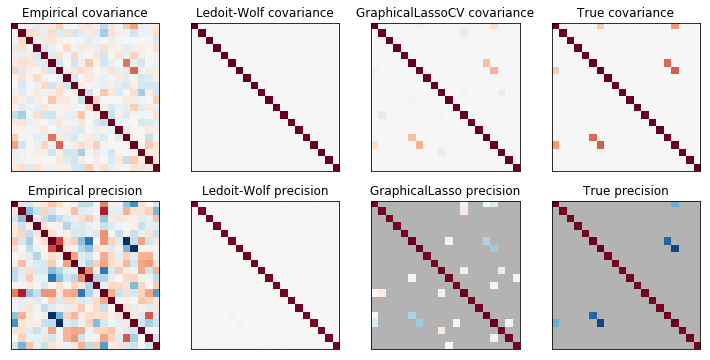

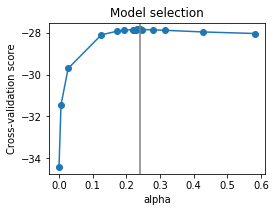

In [3]:
print(__doc__)
# author: Gael Varoquaux <gael.varoquaux@inria.fr>
# License: BSD 3 clause
# Copyright: INRIA

import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
import matplotlib.pyplot as plt

# #############################################################################
# Generate the data
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=prng)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# #############################################################################
# Estimate the covariance
emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV(cv=5)
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

# #############################################################################
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov), ('Ledoit-Wolf', lw_cov_),
        ('GraphicalLassoCV', cov_), ('True', cov)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)


# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)), ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_), ('True', prec)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_alphas_, np.mean(model.grid_scores_, axis=1), 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

In [8]:
X.shape

(60, 20)

In [12]:
prec_

array([[ 1.02640733e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         6.07226223e-04, -0.00000000e+00,  0.00000000e+00,
        -2.14450946e-02, -1.63165512e-01,  0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  1.01052132e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         1.03111689e-01, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.0